# tf_flowers_vgg16_project

## Step 1. 데이터셋 내려받기

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os

In [3]:
# !mkdir -p ~/aiffel/tf_flowers/FlowerImages
# !ln -s ~/data/* ~/aiffel/tf_flowers/

In [4]:
IMG_SIZE = 160 # Image resize

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    download=True,
    with_info=True,
    as_supervised=True,
)

In [5]:
# 데이터셋 확인
print(len(raw_train))
print(len(raw_validation))
print(len(raw_test))

2936
367
367


In [6]:
class_labels = metadata.features['label'].names[:5]

for i, label in enumerate(class_labels):
    print(f"Class {i + 1}: {label}")

Class 1: dandelion
Class 2: daisy
Class 3: tulips
Class 4: sunflowers
Class 5: roses


## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [7]:
# 같은 크기로 변환
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255 
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
# Augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [9]:
train= raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

train = train.map(augment)

In [10]:
print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


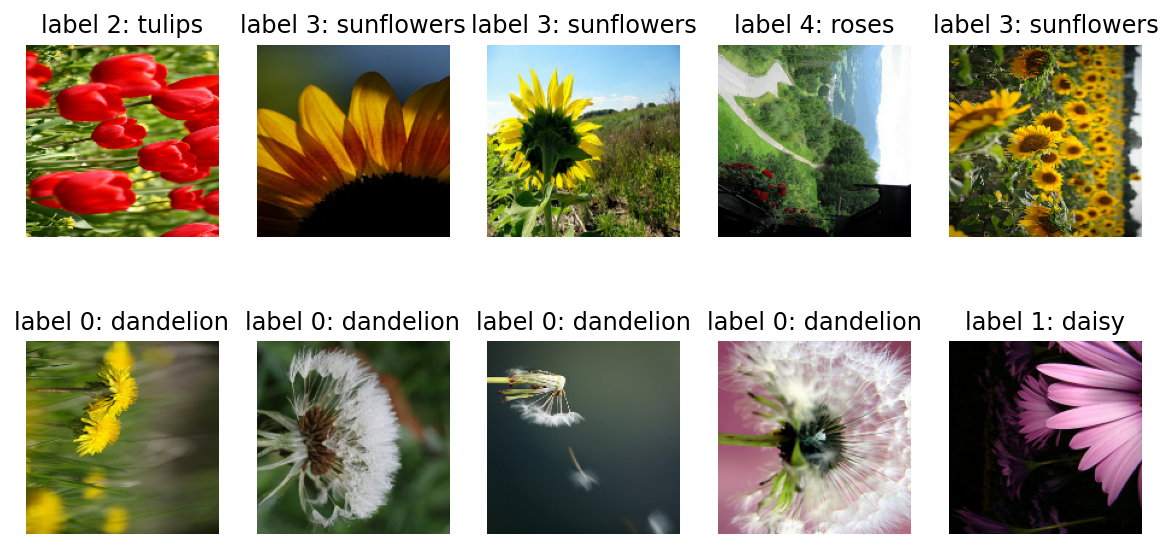

In [12]:
# 시각화
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Step 3. 모델 설계하기

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')


In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
batchnormal_layer = tf.keras.layers.BatchNormalization()
dropout_layer = tf.keras.layers.Dropout(0.2)

In [16]:
# 사전 모델 학습 여부
base_model.trainable = False

In [17]:
base_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    batchnormal_layer,
    dropout_layer,
    prediction_layer
])

In [18]:
# 모델 요약
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,981,957
Trainable params: 266,245
Non-trainable params: 14,715,712
______________________________________

## Step 4. 모델 학습시키기

In [19]:
# compile
base_learning_rate = 0.0001
base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [20]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 1000

In [21]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [22]:
validation_steps=10
loss0, accuracy0 = base_model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 6s 53ms/step - loss: 1.6619 - accuracy: 0.1450
initial loss: 1.66
initial accuracy: 0.14


In [26]:
def lr_schedule(epoch):
    if epoch < 10:
        return base_learning_rate
    else:
        return base_learning_rate * tf.math.exp(0.1 * (10 - epoch))

early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
patience=3,
restore_best_weights=True
)

In [27]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [28]:
EPOCHS = 20
history = base_model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping, lr_scheduler]
                    )

Epoch 1/20
147/147 [==============================] - 15s 91ms/step - loss: 1.1844 - accuracy: 0.5358 - val_loss: 1.2275 - val_accuracy: 0.6485
Epoch 2/20
147/147 [==============================] - 10s 66ms/step - loss: 0.8365 - accuracy: 0.6802 - val_loss: 0.8985 - val_accuracy: 0.7357
Epoch 3/20
147/147 [==============================] - 10s 67ms/step - loss: 0.7432 - accuracy: 0.7275 - val_loss: 0.7051 - val_accuracy: 0.7548
Epoch 4/20
147/147 [==============================] - 11s 68ms/step - loss: 0.6941 - accuracy: 0.7442 - val_loss: 0.6271 - val_accuracy: 0.7684
Epoch 5/20
147/147 [==============================] - 10s 67ms/step - loss: 0.6624 - accuracy: 0.7633 - val_loss: 0.5936 - val_accuracy: 0.7766
Epoch 6/20
147/147 [==============================] - 10s 66ms/step - loss: 0.6420 - accuracy: 0.7626 - val_loss: 0.6132 - val_accuracy: 0.7657
Epoch 7/20
147/147 [==============================] - 10s 66ms/step - loss: 0.6114 - accuracy: 0.7718 - val_loss: 0.5845 - val_accuracy:

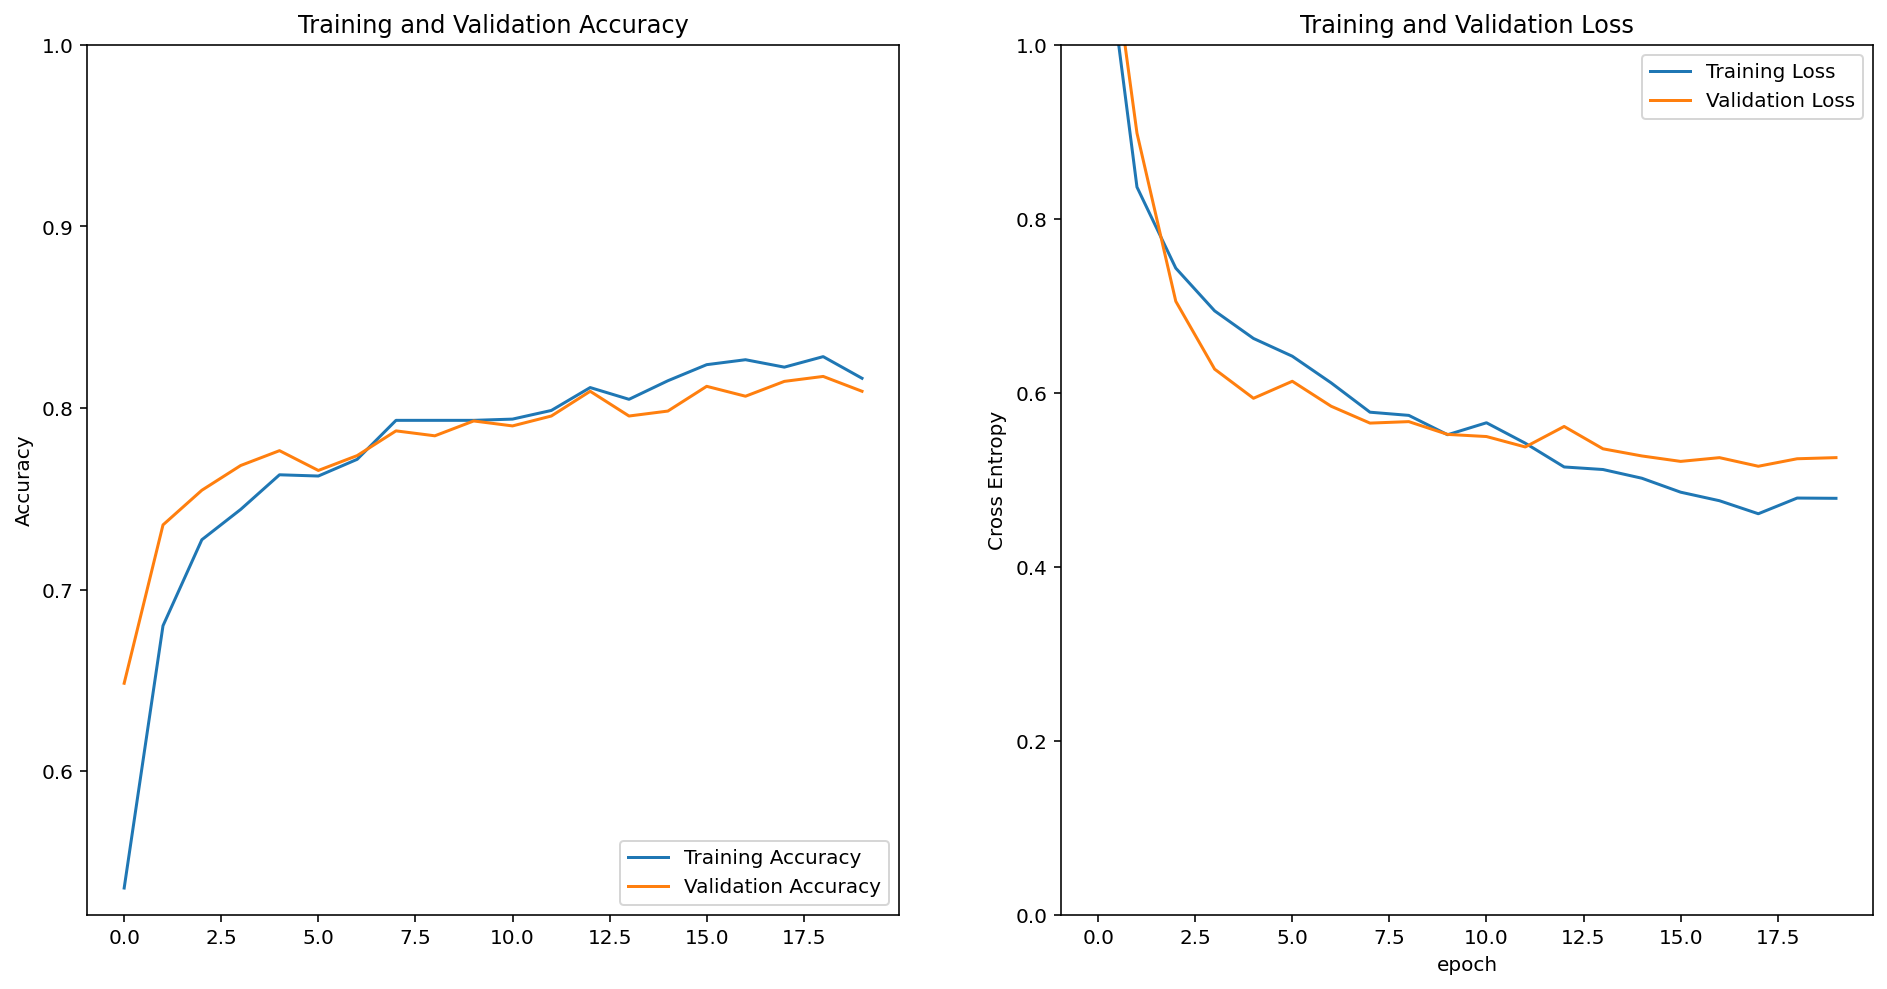

In [29]:
# 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 5. 모델 성능 평가하기

In [30]:
# test_batches 에서 가져와서 예측
import numpy as np
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = base_model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis = 1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4])

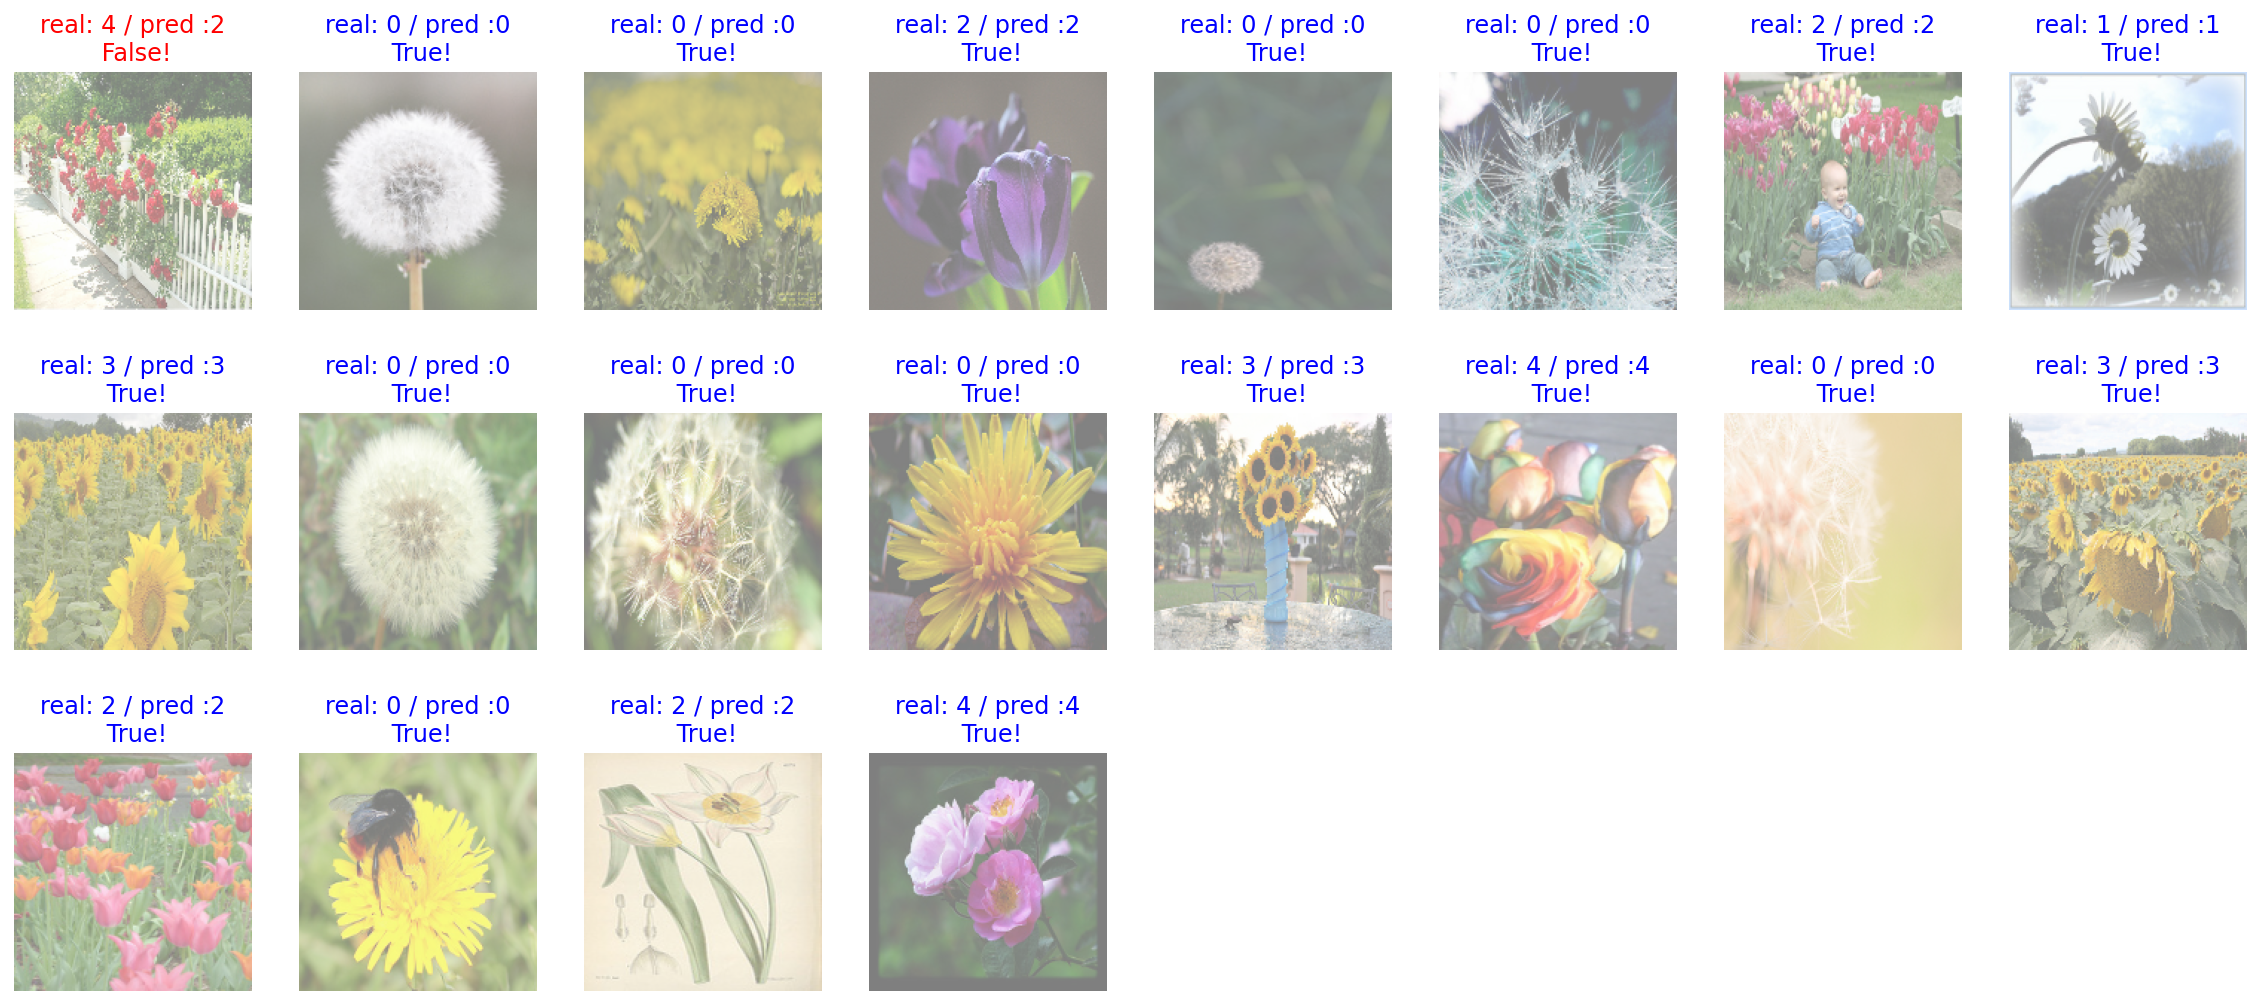

In [31]:
# prediction 값들을 실제 추론한 라벨로 변환
import numpy as np
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [32]:
# Accuracy
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 20 * 100) # correct / batch_size * 100 = accuracy

95.0


## Step 6. 모델 활용하기

In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [34]:
IMG_SIZE = 160
checkpoint_dir = os.getenv("HOME") + "/aiffel/cat_vs_dog/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')

base_model.save_weights(checkpoint_file_path)

if os.path.exists(checkpoint_file_path):
  print('gotcha')


gotcha


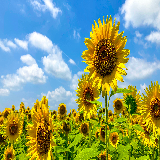

In [35]:
img_dir_path = os.getenv("HOME") + "/aiffel/tf_flowers/FlowerImages"
sunflower_image_path = os.path.join(img_dir_path, 'sunflowers1.jpg')

sunflower_image = load_img(sunflower_image_path, target_size = (IMG_SIZE, IMG_SIZE))
sunflower_image

In [36]:
sunflower_image = img_to_array(sunflower_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
sunflower_image.shape

(1, 160, 160, 3)

In [37]:
def show_and_predict_image(dirpath, filename, img_size = 160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size = (img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = base_model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulips_percentage = round(prediction[2] * 100)
    sunflowers_percentage = round(prediction[3] * 100)
    roses_percentage = round(prediction[4] * 100)
    
    print(f"This image seems: \n{dandelion_percentage}% dandelion, \n{daisy_percentage}% daisy, \n{tulips_percentage}% tulips, \n{sunflowers_percentage}% sunflowers, \n{roses_percentage}% roses")


This image seems: 
0% dandelion, 
0% daisy, 
0% tulips, 
100% sunflowers, 
0% roses


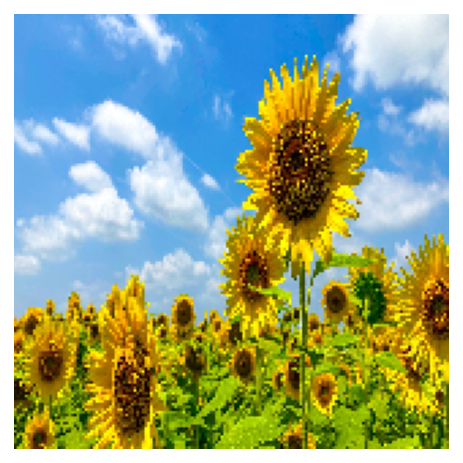

In [38]:
filename = "sunflowers1.jpg"
show_and_predict_image(img_dir_path, filename)